#### Problem Description:
- Assign a given set of orders to plants and carriers to minimize cost.
- select the appropriate plant that processes the order
- select the port from which to send the order to its destination
#### Restrictions
- a given plant can only process certain products
- each plant is only connected to certain ports. 
- some customers have a vendor managed inventory (VMI) which means that they can only be serviced by a certain plant.

In [1]:
!pip install openpyxl

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import networkx as nx

In [3]:
data = pd.ExcelFile("../input/supply-chain-data/Supply chain logisitcs problem.xlsx")

In [4]:
plant_ports = data.parse("PlantPorts")
order_list = data.parse("OrderList")
products_per_plant = data.parse('ProductsPerPlant')
vmi_plants = data.parse("VmiCustomers")
freight_rates = data.parse("FreightRates")
wh_costs = data.parse("WhCosts")
wh_capacities = data.parse("WhCapacities")

In [5]:
plant_ports

,Plant Code,Port
0,PLANT01,PORT01
1,PLANT01,PORT02
2,PLANT02,PORT03
3,PLANT03,PORT04
4,PLANT04,PORT05
5,PLANT05,PORT06
6,PLANT06,PORT06
7,PLANT07,PORT01
8,PLANT07,PORT02
9,PLANT08,PORT04


In [6]:
order_list

,Order ID,Order Date,Origin Port,Carrier,TPT,Service Level,Ship ahead day count,Ship Late Day count,Customer,Product ID,Plant Code,Destination Port,Unit quantity,Weight
0,1.447296e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.300000
1,1.447158e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.940000
2,1.447139e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.200000
3,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,847,16.160000
4,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2163,52.340000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,1.447305e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
9211,1.447319e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
9212,1.447322e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683388,PLANT03,PORT09,245,0.294265
9213,1.447145e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683430,PLANT03,PORT09,278,2.480000


In [7]:
products_per_plant

,Plant Code,Product ID
0,PLANT15,1698815
1,PLANT17,1664419
2,PLANT17,1664426
3,PLANT17,1672826
4,PLANT17,1674916
...,...,...
2031,PLANT04,1699951
2032,PLANT04,1699952
2033,PLANT04,1699953
2034,PLANT04,1699954


In [8]:
vmi_plants

,Plant Code,Customers
0,PLANT02,V5555555555555_16
1,PLANT02,V555555555555555_29
2,PLANT02,V555555555_3
3,PLANT02,V55555555555555_8
4,PLANT02,V55555555_9
5,PLANT02,V55555_10
6,PLANT02,V55555555_5
7,PLANT06,V555555555555555_18
8,PLANT06,V55555_10
9,PLANT10,V555555555555555_29


In [9]:
freight_rates

,Carrier,orig_port_cd,dest_port_cd,minm_wgh_qty,max_wgh_qty,svc_cd,minimum cost,rate,mode_dsc,tpt_day_cnt,Carrier type
0,V444_6,PORT08,PORT09,250.0,499.99,DTD,43.2272,0.7132,AIR,2,V88888888_0
1,V444_6,PORT08,PORT09,65.0,69.99,DTD,43.2272,0.7512,AIR,2,V88888888_0
2,V444_6,PORT08,PORT09,60.0,64.99,DTD,43.2272,0.7892,AIR,2,V88888888_0
3,V444_6,PORT08,PORT09,50.0,54.99,DTD,43.2272,0.8272,AIR,2,V88888888_0
4,V444_6,PORT08,PORT09,35.0,39.99,DTD,43.2272,1.0552,AIR,2,V88888888_0
...,...,...,...,...,...,...,...,...,...,...,...
1535,V444_8,PORT03,PORT09,0.0,99.99,DTD,29.3392,0.4116,AIR,0,V88888888_0
1536,V444_8,PORT03,PORT09,500.0,1999.99,DTD,29.3392,0.3112,AIR,0,V88888888_0
1537,V444_8,PORT03,PORT09,250.0,499.99,DTD,29.3392,0.4116,AIR,0,V88888888_0
1538,V444_8,PORT03,PORT09,2000.0,99999.99,DTD,29.3392,0.3112,AIR,0,V88888888_0


In [10]:
wh_costs.set_index("WH", inplace=True)
wh_costs

,Cost/unit
WH,
PLANT15,1.415063
PLANT17,0.428947
PLANT18,2.036254
PLANT05,0.488144
PLANT02,0.477504
PLANT01,0.566976
PLANT06,0.554088
PLANT10,0.493582
PLANT07,0.371424


In [11]:
wh_capacities

,Plant ID,Daily Capacity
0,PLANT15,11
1,PLANT17,8
2,PLANT18,111
3,PLANT05,385
4,PLANT02,138
5,PLANT01,1070
6,PLANT06,49
7,PLANT10,118
8,PLANT07,265
9,PLANT14,549


In [12]:
def column_name_change(sheet):
    return [column.replace(" ", "_").lower() for column in sheet.columns]

In [13]:
# Changing column names in each sheet
order_list.columns = column_name_change(order_list)
products_per_plant.columns = column_name_change(products_per_plant)
plant_ports.columns = column_name_change(plant_ports)
vmi_plants.columns= column_name_change(vmi_plants)
freight_rates.columns = column_name_change(freight_rates)
wh_costs.columns = column_name_change(wh_costs)
wh_capacities.columns = column_name_change(wh_capacities)

In [14]:
plant_ports

,plant_code,port
0,PLANT01,PORT01
1,PLANT01,PORT02
2,PLANT02,PORT03
3,PLANT03,PORT04
4,PLANT04,PORT05
5,PLANT05,PORT06
6,PLANT06,PORT06
7,PLANT07,PORT01
8,PLANT07,PORT02
9,PLANT08,PORT04


In [15]:
network_graph_plant_ports = nx.from_pandas_edgelist(plant_ports, source='plant_code', target='port')

In [16]:
network_graph_plant_ports.edges

EdgeView([('PLANT01', 'PORT01'), ('PLANT01', 'PORT02'), ('PORT01', 'PLANT07'), ('PORT01', 'PLANT10'), ('PORT02', 'PLANT07'), ('PORT02', 'PLANT10'), ('PLANT02', 'PORT03'), ('PLANT03', 'PORT04'), ('PORT04', 'PLANT08'), ('PORT04', 'PLANT09'), ('PORT04', 'PLANT11'), ('PORT04', 'PLANT12'), ('PORT04', 'PLANT13'), ('PORT04', 'PLANT19'), ('PLANT04', 'PORT05'), ('PLANT05', 'PORT06'), ('PORT06', 'PLANT06'), ('PLANT14', 'PORT07'), ('PLANT15', 'PORT08'), ('PLANT16', 'PORT09'), ('PLANT17', 'PORT10'), ('PLANT18', 'PORT11')])

In [17]:
network_graph_plant_ports.degree

DegreeView({'PLANT01': 2, 'PORT01': 3, 'PORT02': 3, 'PLANT02': 1, 'PORT03': 1, 'PLANT03': 1, 'PORT04': 7, 'PLANT04': 1, 'PORT05': 1, 'PLANT05': 1, 'PORT06': 2, 'PLANT06': 1, 'PLANT07': 2, 'PLANT08': 1, 'PLANT09': 1, 'PLANT10': 2, 'PLANT11': 1, 'PLANT12': 1, 'PLANT13': 1, 'PLANT14': 1, 'PORT07': 1, 'PLANT15': 1, 'PORT08': 1, 'PLANT16': 1, 'PORT09': 1, 'PLANT17': 1, 'PORT10': 1, 'PLANT18': 1, 'PORT11': 1, 'PLANT19': 1})

In [18]:
network_graph_plant_ports.nodes

NodeView(('PLANT01', 'PORT01', 'PORT02', 'PLANT02', 'PORT03', 'PLANT03', 'PORT04', 'PLANT04', 'PORT05', 'PLANT05', 'PORT06', 'PLANT06', 'PLANT07', 'PLANT08', 'PLANT09', 'PLANT10', 'PLANT11', 'PLANT12', 'PLANT13', 'PLANT14', 'PORT07', 'PLANT15', 'PORT08', 'PLANT16', 'PORT09', 'PLANT17', 'PORT10', 'PLANT18', 'PORT11', 'PLANT19'))

In [19]:
layout = nx.bipartite_layout(network_graph_plant_ports, plant_ports.plant_code)
layout

{'PLANT08': array([-0.57894737, -0.59210526]),
 'PLANT18': array([-0.57894737, -0.52631579]),
 'PLANT01': array([-0.57894737, -0.46052632]),
 'PLANT06': array([-0.57894737, -0.39473684]),
 'PLANT07': array([-0.57894737, -0.32894737]),
 'PLANT12': array([-0.57894737, -0.26315789]),
 'PLANT04': array([-0.57894737, -0.19736842]),
 'PLANT11': array([-0.57894737, -0.13157895]),
 'PLANT02': array([-0.57894737, -0.06578947]),
 'PLANT10': array([-5.78947368e-01,  4.38245931e-18]),
 'PLANT05': array([-0.57894737,  0.06578947]),
 'PLANT09': array([-0.57894737,  0.13157895]),
 'PLANT16': array([-0.57894737,  0.19736842]),
 'PLANT14': array([-0.57894737,  0.26315789]),
 'PLANT17': array([-0.57894737,  0.32894737]),
 'PLANT03': array([-0.57894737,  0.39473684]),
 'PLANT13': array([-0.57894737,  0.46052632]),
 'PLANT15': array([-0.57894737,  0.52631579]),
 'PLANT19': array([-0.57894737,  0.59210526]),
 'PORT06': array([ 1.        , -0.59210526]),
 'PORT07': array([ 1.        , -0.47368421]),
 'PORT0

In [20]:
edge_x = []
edge_y = []

for edge in network_graph_plant_ports.edges():
    x0, y0 = layout[edge[0]]
    x1, y1 = layout[edge[1]]
    
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
    edge_trace = go.Scatter(x=edge_x, y=edge_y,line=dict(width=0.5, color="#25488e"), hoverinfo='none', mode='lines' )
    

node_x = []
node_y = []
for node in network_graph_plant_ports.nodes():
    x, y = layout[node]
    node_x.append(x)
    node_y.append(y)
degrees = dict(network_graph_plant_ports.degree)      
maps = [value for value in degrees.values()]     
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=maps,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_trace.text = [i + " Number of Links: " + str(degrees[i]) for i in degrees]

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Bipartite Graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[dict(text="Factories",
                     showarrow=False,
                     xref="paper", yref="paper",
                     x=0.005, y=-0.002 ),
                             dict(text="Ports",
                     showarrow=False,
                     xref="paper", yref="paper",
                     x=0.95, y=-0.002 )],
                xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                yaxis=dict(showgrid=True, zeroline=False, showticklabels=True))
                )
fig

Port4 have most number of links when compared to other ports 

In [21]:
order_list.head()

,order_id,order_date,origin_port,carrier,tpt,service_level,ship_ahead_day_count,ship_late_day_count,customer,product_id,plant_code,destination_port,unit_quantity,weight
0,1.447296e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.30
1,1.447158e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.94
2,1.447139e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.20
3,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,847,16.16
4,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2163,52.34


In [22]:
order_list.columns

Index(['order_id', 'order_date', 'origin_port', 'carrier', 'tpt',
       'service_level', 'ship_ahead_day_count', 'ship_late_day_count',
       'customer', 'product_id', 'plant_code', 'destination_port',
       'unit_quantity', 'weight'],
      dtype='object')

In [23]:
new_order_list = order_list.drop(columns=['order_date', 'origin_port', 'carrier', 'tpt',
       'service_level', 'ship_ahead_day_count', 'ship_late_day_count'])
new_order_list

,order_id,customer,product_id,plant_code,destination_port,unit_quantity,weight
0,1.447296e+09,V55555_53,1700106,PLANT16,PORT09,808,14.300000
1,1.447158e+09,V55555_53,1700106,PLANT16,PORT09,3188,87.940000
2,1.447139e+09,V55555_53,1700106,PLANT16,PORT09,2331,61.200000
3,1.447364e+09,V55555_53,1700106,PLANT16,PORT09,847,16.160000
4,1.447364e+09,V55555_53,1700106,PLANT16,PORT09,2163,52.340000
...,...,...,...,...,...,...,...
9210,1.447305e+09,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
9211,1.447319e+09,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
9212,1.447322e+09,V55555555555555_8,1683388,PLANT03,PORT09,245,0.294265
9213,1.447145e+09,V55555555555555_8,1683430,PLANT03,PORT09,278,2.480000


In [24]:
new_order_list.set_index('order_id', inplace=True)
new_order_list

,customer,product_id,plant_code,destination_port,unit_quantity,weight
order_id,,,,,,
1.447296e+09,V55555_53,1700106,PLANT16,PORT09,808,14.300000
1.447158e+09,V55555_53,1700106,PLANT16,PORT09,3188,87.940000
1.447139e+09,V55555_53,1700106,PLANT16,PORT09,2331,61.200000
1.447364e+09,V55555_53,1700106,PLANT16,PORT09,847,16.160000
1.447364e+09,V55555_53,1700106,PLANT16,PORT09,2163,52.340000
...,...,...,...,...,...,...
1.447305e+09,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
1.447319e+09,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
1.447322e+09,V55555555555555_8,1683388,PLANT03,PORT09,245,0.294265


In [25]:
freight_rates.columns

Index(['carrier', 'orig_port_cd', 'dest_port_cd', 'minm_wgh_qty',
       'max_wgh_qty', 'svc_cd', 'minimum_cost', 'rate', 'mode_dsc',
       'tpt_day_cnt', 'carrier_type'],
      dtype='object')

In [26]:
freight_rates.drop(columns=["dest_port_cd", "carrier_type", "svc_cd"], inplace=True)

In [27]:
freight_rates

,carrier,orig_port_cd,minm_wgh_qty,max_wgh_qty,minimum_cost,rate,mode_dsc,tpt_day_cnt
0,V444_6,PORT08,250.0,499.99,43.2272,0.7132,AIR,2
1,V444_6,PORT08,65.0,69.99,43.2272,0.7512,AIR,2
2,V444_6,PORT08,60.0,64.99,43.2272,0.7892,AIR,2
3,V444_6,PORT08,50.0,54.99,43.2272,0.8272,AIR,2
4,V444_6,PORT08,35.0,39.99,43.2272,1.0552,AIR,2
...,...,...,...,...,...,...,...,...
1535,V444_8,PORT03,0.0,99.99,29.3392,0.4116,AIR,0
1536,V444_8,PORT03,500.0,1999.99,29.3392,0.3112,AIR,0
1537,V444_8,PORT03,250.0,499.99,29.3392,0.4116,AIR,0
1538,V444_8,PORT03,2000.0,99999.99,29.3392,0.3112,AIR,0


In [28]:
# given a product id, return the plants that can produce this product.
def product_restriction(index):
    data = new_order_list.loc[index]
    product_id = data["product_id"]
    possible_plants = products_per_plant.loc[products_per_plant["product_id"] == product_id]
    return np.array(possible_plants["plant_code"])

In [29]:
# vmi restriction: check if a given customer has to be serviced by a specific facility, else return all facilities as possibilities.
def customer_restriction(index):
    data = new_order_list.loc[index]
    Customer_id = data["customer"]
    possible_plants = vmi_plants.loc[vmi_plants["customers"] == Customer_id]
    if list(possible_plants["plant_code"]) == []:
        return plant_ports["plant_code"].unique()
    else:
        return np.array(possible_plants["plant_code"])

In [30]:
# combine both the product and vmi restriction. There will be orders for which only one, or possibly even 0, facilities can fullfil it.
def check_order(order_id, length=True):
    if length:
        return len(np.intersect1d(customer_restriction(order_id), product_restriction(order_id)))
    else:
        return np.intersect1d(customer_restriction(order_id), product_restriction(order_id))

In [31]:
new_order_list["decision_space_size"] = np.array(list(map(check_order, new_order_list.index)))

In [32]:
new_order_list["decision_space_size"].value_counts()

decision_space_size
1    6275
0    1045
4     982
2     785
3     127
5       1
Name: count, dtype: int64

We can see that for most orders, there is only one facility that can handle the order. For ~1,000 there is no possible facility that can handle the order given our problem restrictions, we will exclude these orders from our further optimization problem.

In [33]:
freight_rates["rate"].describe()

count    1540.000000
mean        2.892656
std         4.603877
min         0.033200
25%         0.470400
50%         1.661200
75%         3.932200
max       128.027200
Name: rate, dtype: float64

In [34]:
ports_agg = freight_rates.groupby(["orig_port_cd"]).agg(avg_rate=("rate", np.mean))

In [35]:
new_order_list = new_order_list.loc[new_order_list.decision_space_size != 0]

In [36]:
new_order_list["decision_space_plants"] = np.array((map(lambda x: check_order(x, length=False), new_order_list.index)))

/tmp/ipykernel_19/2707852808.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
def min_cost(dec_space):
    
    plant_port_cost = {}
    
    wh = wh_costs.copy()
    min_cost = np.inf
    
    for plant in dec_space:
        plant_port_cost[plant] = wh.loc[plant].iloc[0]
        port_price, port = find_best_port(plant)
        plant_port_cost[plant] += port_price
        
        if plant_port_cost[plant] < min_cost:
            min_cost = plant_port_cost[plant]
            best_plant = plant
            best_port = port
            best_port_price = port_price
        
    return min_cost, best_plant, best_port_price, best_port

In [38]:
# given a port and the order specifications return the carrier that can handle the product at the best price.
def find_best_port(plant_id):
    # choose the ports that have a connection to the given plant and then find the port with the lowest freight rate
    possible_ports = plant_ports.loc[(plant_ports.plant_code == plant_id) & (plant_ports.port != "PORT01"), "port"]
    possible_ports = ports_agg.loc[possible_ports]
    return possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0]["avg_rate"], possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0].name
    

In [39]:
new_order_list["decision"] = new_order_list["decision_space_plants"].apply(min_cost)

/tmp/ipykernel_19/3562036597.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
new_order_list["decision"]

order_id
1.447296e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447158e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447139e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
                                      ...                        
1.447372e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447372e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447328e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447358e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447287e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
Name: decision, Length: 8170, dtype: object

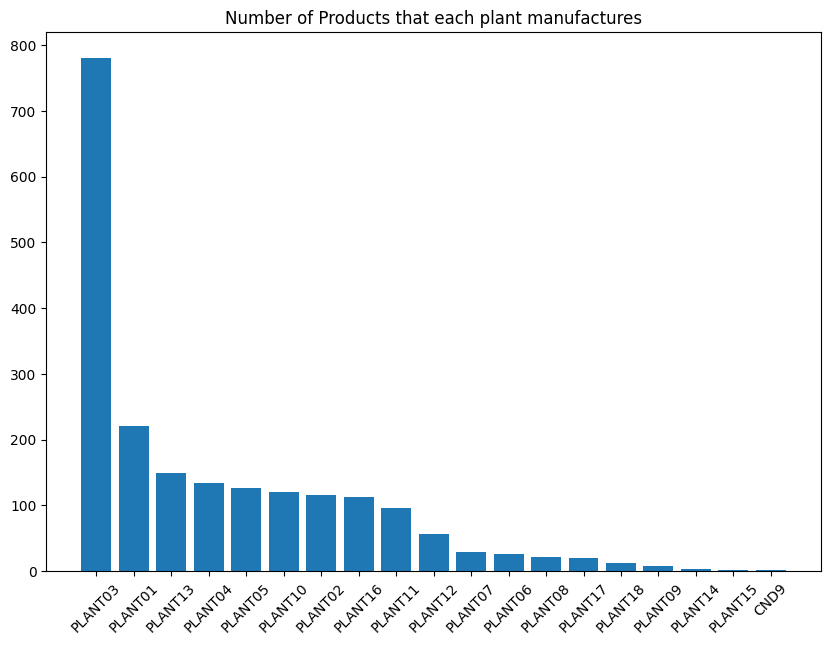

In [41]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
plant_counts = pd.DataFrame(products_per_plant["plant_code"].value_counts().reset_index())
plant_counts.columns = ['plant_code', 'count']
ax.bar(plant_counts['plant_code'], plant_counts['count'])

plt.title("Number of Products that each plant manufactures")
plt.show()

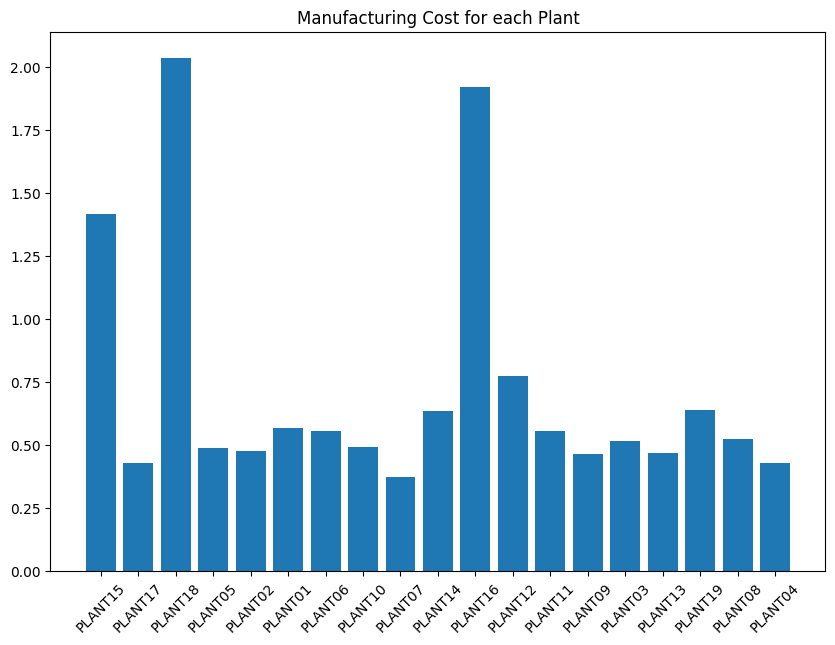

In [42]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
ax.bar(wh_costs.index, wh_costs["cost/unit"])
plt.title("Manufacturing Cost for each Plant")
plt.show()

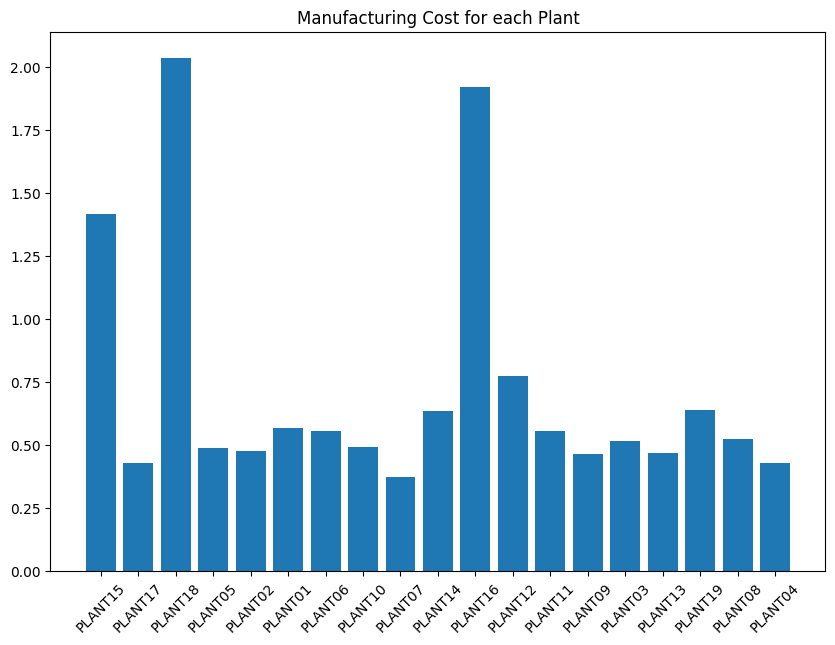

In [43]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
ax.bar(wh_costs.index, wh_costs["cost/unit"])
plt.title("Manufacturing Cost for each Plant")
plt.show()